<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >

# Pivot Tables

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [7]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308  

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# Pandas 0.19 버전 기준 호출 시그니처
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [8]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [9]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, [this blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [10]:
# s데이터 다운로드를 위한 셸 명령어:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [11]:
births = pd.read_csv('data/births.csv')

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [12]:
births.head()

,year,month,day,gender,births
0,1969,1,1,F,4046
1,1969,1,1,M,4440
2,1969,1,2,F,4454
3,1969,1,2,M,4548
4,1969,1,3,F,4548


We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

In [13]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

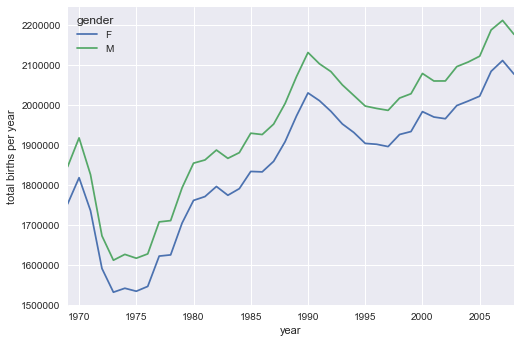

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # Seaborn 스타일 사용
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

### Further data exploration

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [15]:
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

With this we can use the ``query()`` method (discussed further in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)) to filter-out rows with births outside these values:

In [16]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [17]:
# 'day'열을 정수형으로 설정; 원래는 널 값 때문에 문자열이었음
births['day'] = births['day'].astype(int)

Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

In [18]:
# 년(year), 월(month), 일(day)로부터 날짜(datetime) 인덱스를 생성 
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this we can plot births by weekday for several decades:

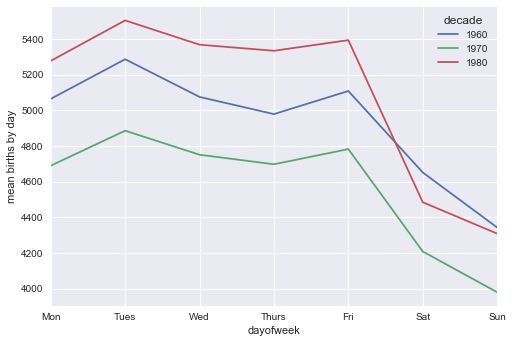

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

In [20]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [21]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

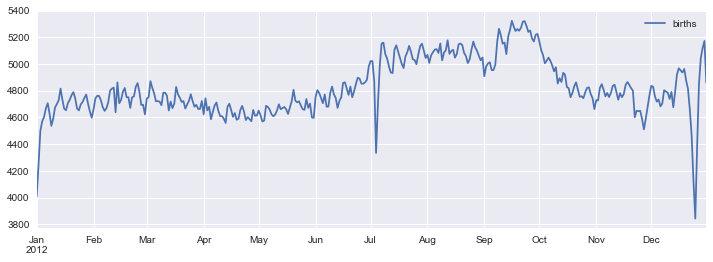

In [22]:
# 결과 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion on this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), where we will use Matplotlib's tools to annotate this plot.

Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets.
We will see some more sophisticated applications of these data manipulations in future sections!

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >